# Question 1

On raisonne de manière infinitésimale en notant $Q_j(t)$ la charge du véhicule $j$ au temps $t$. Lorsque le véhicule est en charge, la station fournit au véhicule $j$ une puissance $P_j(t)$, et la voiture est capable de capter une certaine fraction $\beta_j$ de cette puissance ($\beta_j$ sera proche de 1 pour une batterie neuve, et tendra vers 0 quand la batterie s'use). Ainsi, la dérivée de la charge du véhicule (en terme de dimension, $Q_j$ sera une énergie) vaut $\frac{dQ_j(t)}{dt} = \beta_j P_j(t)$.

Si partitionne notre intervalle de temps en N intervalles $[t_i, t_{i+1}]$ de durée $\Delta t$ (qui est donc la plus petite durée considérée), cette équation s'approxime par $\frac{Q_j(t + \Delta t) - Q_j(t)}{\Delta t} = \beta_j P_j(t)$ ou encore $\frac{Q_{j, i+1} - Q_{j, i}}{\Delta t} = \beta_j P_{j,i}$ i.e :
$$
Q_{j, i+1} =  Q_{j, i} + \Delta t \beta_j P_{j,i}
$$

# Question 2 

Le problème énoncé correspond au problème d'optimisation suivant : 
$\min\limits_{x} f(x)$ tel que $c_{eq}(x) = 0$ et $c_{in}(x) \leq 0$  

f est la fonction qui, à x, associe le coût électrique de charge, qu'on cherche à minimiser ; autrement dit :
$$
f : x = (Q_{j,i}, P_{j,i})_{0 \leq i < N ; 1 \leq j \leq N_{\nu}} \longmapsto {\Delta t}\sum_{j=1}^{N_v}\sum_{i=0}^{N}c_iP_{j,i}.
$$

Les contraintes d'égalité sont les suivantes :

$$
c_{eq} : x \mapsto \begin{pmatrix}
Q_{j,i+1} - Q_{j,i} - {\Delta t}\beta_jP_{j,i} \\
Q_{j,\frac{t_j^{in}}{\Delta t}} - Q_j^in \\
Q_{j,\frac{t_j^f}{\Delta t}} - \bar{Q_j}\\
\end{pmatrix}
$$



Les contraintes d'inégalités sont les suivantes :


$$
c_{in} : x \mapsto \begin{pmatrix}
\bar{P} - \sum^{N_\nu}_{j=1}P_{j,i} \\
Q_{j,i} \\
\bar{Q_j} - Q_{j,i}\\
\end{pmatrix}
$$



# Question 3

Un problème est convexe à deux conditions :
- la fonction à minimiser doit être convexe
- l'espace des valeurs vérifiant l'ensemble des contraintes doit être convexe.

Dans ce problème, les deux conditions sont vérifiées. En effet, d'une part la fonction f est convexe comme fonction linéaire. D'autre part, les contraintes d'égalité et d'inégalité vérifiées sont affines, donc l'ensemble des valeurs les vérifiant est convexe comme intersection de convexes.

On a donc bien un problème convexe.

# Question 4

On a $\frac{dQ}{dt} = \beta P$ où $P = UI$ et $SOC = \frac{Q}{\bar{Q}}$ donc $\bar{Q}\frac{dSOC}{dt} = \beta UI$. Il s'agit de trouver le meilleur $\beta$ pour avoir $(\frac{dSOC}{dt})_i \approx \beta \frac{UI_i}{\bar{Q}}$. Dans la pratique il va falloir résoudre $\min\limits_{\beta} \sum_{i}|(\frac{dSOC}{dt})_i - \beta \frac{UI_i}{\bar{Q}}|^2$.

# Question 5

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data_battery.csv")
df

,Time [s],SOC [%],I [kA]
0,0.000000,0.631635,0.000153
1,1.005016,0.631646,0.000951
2,2.008215,0.630583,-0.002994
3,3.018137,0.630439,0.000654
4,4.023168,0.632332,0.002940
...,...,...,...
294,295.401837,0.262350,-0.482445
295,296.407886,0.259741,-0.482207
296,297.413096,0.258567,-0.484523
297,298.418893,0.258645,-0.480281


In [11]:
Q_bar = 50 * 60 * 60 # 50 Ah
U = 230 # 230 V
I = df['I [kA]'].to_numpy()

temps = df['Time [s]'].to_numpy()
soc = df['SOC [%]'].to_numpy()

def derivee(temps, valeurs):
    # Calculer les différences entre les valeurs adjacentes
    delta_temps = np.diff(temps)
    delta_valeurs = np.diff(valeurs)
    return delta_valeurs / delta_temps

dsoc_dt = derivee(temps, soc)

Soit $f : \beta \mapsto \sum_{i}((\frac{dSOC}{dt})_i - \beta \frac{UI_i}{\bar{Q}})^2$. f est une fonction polynomiale du second degré, convexe (car positive car somme de carrés), donc elle atteint son minimum lorsque sa dérivée s'annule.

$f'(\beta) = \sum_{i}-2 \frac{UI_i}{\bar{Q}}((\frac{dSOC}{dt})_i - \beta \frac{UI_i}{\bar{Q}})$ donc $f'(\beta) = 0 \iff  \beta = \frac{\sum_i \frac{UI_i}{\bar{Q}}(\frac{dSOC}{dt})_i } {\sum_i (\frac{UI_i}{\bar{Q}})^2}$

Le minimum est atteint en : 
$$
\beta^* = \frac{\sum_i \frac{UI_i}{\bar{Q}}(\frac{dSOC}{dt})_i } {\sum_i (\frac{UI_i}{\bar{Q}})^2}
$$

In [12]:
# Calcul de beta 

beta = sum([U*I[i] / Q_bar * dsoc_dt[i] for i in range(0, len(dsoc_dt))]) / sum([(U*I[i] / Q_bar)**2 for i in range(0, len(dsoc_dt))])
beta

2.9829082296414215

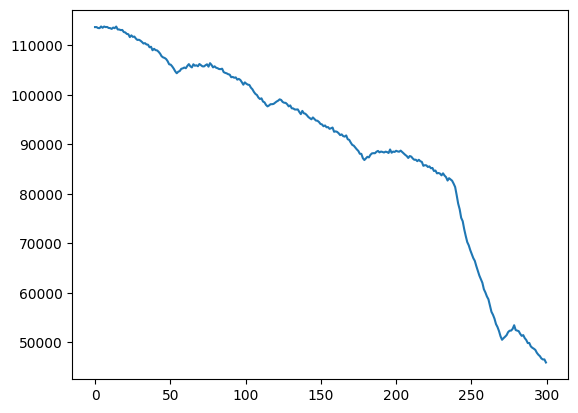

In [14]:
# Tracons l’évolution de l’état de charge de la batterie au cours du temps
P = U * I
Q = soc * Q_bar
plt.plot(temps, Q)
plt.show()

# Question 6

Pour résoudre ce problème, on peut utiliser des algorithmes type Uzawa.

## L'algorithme 

In [33]:
import casadi as ca

# Temps
t0 = 17 # h
Dt = 0.25 # h
N = int(24 / Dt)
temps = [t0 + Dt*i for i in range(0, N)] # vecteur temps
Nv = 2 # nombre de voitures

# Caracteristiques physiques
ccr = 1
cpl = 3/2
Q_bar = 50 # Ah
P_bar = 2.5 * 1000 # W
beta = 2.9829082296414215

# creation du vecteur tarif c
c = []
for t in temps :
    if (t >= 24 and t < 30) or (t >= 36 and t < 38) : # heures creuses : 6h a minuit ou midi a 14h
        c.append(ccr)
    else :
        c.append(cpl)
c = ca.reshape(ca.vertcat(c), 1, N)

# Temps d'arrivee et de depart
t1_in = 18 # h
t1_f = 32 # h (8h le lendemain)
t2_in = 18.5 # h
t2_f = 33.5 # h (9h le lendemain) 

# Charges a l'arrivee
Q1_in = 0.3 * Q_bar # 30 %
Q2_in = 0.5 * Q_bar # 50 %

# Définition des variables de décision
x = ca.MX.sym('x', 2*N*Nv)

# Séparation des variables Q et P
Q = x[:N*Nv]
P = ca.reshape(x[N*Nv:], Nv, N).T

# Calcul de la fonction objective
obj = Dt * ca.sum1(ca.mtimes(ca.reshape(P, N, Nv), ca.reshape(ca.vertcat(c), N, 1)))

# Contraintes d'égalité
ceq = []
for j in range(Nv):
    for i in range(N-1):
        ceq.append(Q[(i+1)*Nv+j] - Q[i*Nv+j] - Dt * beta[j] * P[i*Nv+j]) # Equation 1
    ceq.append(Q[int(t1_in/Dt)*Nv+j] - Q1_in) # Equation 2
    ceq.append(Q[int(t1_f/Dt)*Nv+j] - Q_bar) # Equation 3
# Empilement des contraintes d'égalité en une seule matrice
ceq = ca.vertcat(*ceq)

# Contraintes d'inégalité
cin = []
for i in range(N):
    cin.append(P_bar - ca.sum1(P[i*Nv:(i+1)*Nv])) # Equation 1
    for j in range(Nv):
        cin.append(Q[j*N+i] - 0) # Equation 2
        cin.append(Q_bar - Q[j*N+i]) # Equation 3
cin = ca.vertcat(*cin)

# Création de la fonction objectif et des contraintes
nlp = {'x': x, 'f': obj, 'g': ca.vertcat(ceq, cin)}

# Options pour le solveur IPOPT
opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.tol': 1e-6}

# Création de l'objet solveur
solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

# Résolution du problème d'optimisation
x0 = [0.1]*(2*N*Nv)  # Exemple de valeurs initiales pour les variables de décision
sol = solver(x0=x0)

RuntimeError: .../casadi/core/sparsity.cpp:431: Assertion "x.size2()==y.size1()" failed:
Matrix product with incompatible dimensions. Lhs is 96x2 and rhs is 96x1.

In [34]:
print("Dimensions de P :", P.size())
print("Dimensions de c :", c.size())


Dimensions de P : (96, 2)
Dimensions de c : (1, 96)
